# Name Competition with Naive Bayes Predictor

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* Classifying names based on a simple naive Bayesian predictor with conditional probabilities estimated from histograms of the training set

In [3]:
import numpy as np
import string

Load file from data and convert to training set and test set (reading from two distinct files)


In [4]:
def read_file(filename):
    with open(filename) as f:
        content = f.readlines()
    y = [line[0] for line in content]    
    X = [line[2:].strip() for line in content]
    return X,y

X_train,y_train = read_file('Names_data_train_large.txt')
X_test,y_test = read_file('Names_data_test.txt')

Class for the naive Bayes classifier. It is based on a feature vector
\begin{equation*}
\boldsymbol{x} = \begin{pmatrix} x_1 & \cdots & x_m\end{pmatrix}^\mathrm{T}
\end{equation*}
where each $x_i$ represent a letter from the word (in its integer, ASCII representation).

The classifier works by application of the Bayes theorem:
$$
P(y|x_1,\ldots, x_m) = \frac{P(x_1,\ldots, x_m|y)P(y)}{P(x_1,\ldots,x_m)}
$$
Therein, we decompose $P(x_1,\ldots,x_m|y)$ using the chain rule of conditional probability as
\begin{align*}
P(x_1,\ldots,x_m|y) &= P(x_1|y,x_2,\ldots, x_m)P(x_2|y,x_3,\ldots,x_m)\cdots P(x_m|y) \\
&= \prod_{i=1}^mP(x_i|y,x_{i+1},\ldots, x_m)
\end{align*}
To simplify the computation, we next make an input assumption that the features $x_i$ are conditionally independent given the observation $y$. Of course, this is not the case in the letters of words, we some combinations can occur more often than others (for instance, a "q" is almost always followed by a "u"), but we use it as a first approach. This conditional independence leads to (consider the example with $m=2$, where $P(x_1,x_2|y) = P(x_1|y)P(x_2|y)$ and hence, by writing $P(x_1,x_2|y) = P(x_1|y,x_2)P(x_2|y)$ we get $P(x_1|y,x_2) = P(x_1|y)$)
$$
P(x_1,\ldots,x_m|y) = \prod_{i=1}^mP(x_i|y)
$$
Hence, we can write finally
\begin{align*}
\hat{y} &= \arg\max_{y}P(y|\boldsymbol{x}) \\
&= \arg\max_y \frac{P(x_1,\ldots, x_m|y)P(y)}{P(x_1,\ldots,x_m)} \\
&\stackrel{(i)}{=} \arg\max_y P(x_1,\ldots, x_m|y)P(y) \\
&= \arg\max_y P(y) \prod_{i=1}^mP(x_i|y)
\end{align*}
where $(i)$ is due to the fact that $P(x_1,\ldots, x_m)$ is constant and doesn't change the maximization.

From our training set, we can easily measure histograms for $P(y)$ (i.e., $P(\mathsf{y} = +)$ and $P(\mathsf{y}=-)$) and also for $P(x_i|y)$. Another alternative would be to fit a distribution (e.g., a Gaussian) to $P(x_i|y)$ but we have some domain knowledge that the letters are probably not Gaussian distributed, so this wouldn't be a good fit

Note that usually, we would write $\hat{y} = \arg\max_y \ln P(y) + \sum_{i=1}^m \ln P(x_i|y)$ and compute the logarithms of $P(x_i|y)$ (the so-called log-likelihoods) to ease implementation and avoid numerical fallacies. But due to the small dimensionality of the problem, this can be avoided here.

***

Next, we develop a class that does the training. Essentially the $\texttt{fit}$ function computes the aforementioned histograms of $P(y)$ and $P(x_i|y)$ where $x_i$ is the $i$-th letter of the word. We can specify as a parameter the number of letters to consider (starting from left). If a name is shorter, it is filled with spaces (this will add a bias if many short names are present!). Ideally we should remove spaces, but as we are not yet sure if the position of a space would influence the estimate, we will avoid this here

In [5]:
class Naive_Bayes():
    '''
    Class for training a very naive Bayes estimator which generates a histogram from the training set
    
    Parameter is the number of letters of the word to consider
    '''    
    def __init__( self, letters ):
        self.letters = letters
        
    # compute the histograms P(Y) (stored in self.Py) and P(x_i|y) (stored in self.Px)
    def fit( self, X, y) :       
        # convert to numeric entries
        ty = np.zeros( len(y) )
        for k in range( len(y) ):
            if y[k]=='+':
                ty[k] = 1
        
        tX = np.empty( (0, self.letters) )
        for mys in X:
            if len(mys) < self.letters:             
                # add spaces if string is too short
                mys += ( ' ' * (self.letters-len(mys) ) )
            tX = np.vstack( (tX, [ord(x) for x in mys[0:self.letters] ] ) )
        
        # compute histograms        
        ordrange = np.arange(int(np.amin(tX)), int( np.amax(tX) )+1)
        self.Py = np.array( [1-np.mean(ty), np.mean(ty)] )  

        self.Px = [ {} for _ in range(self.letters) ]
        for pos in range( self.letters ):
            summe = np.array([0,0])
            for ii in ordrange:
                # Compute p(x_i=ii|y=0)
                pxgy0 = sum( tX[ty==0, pos]==ii ) / tX[ty==0, pos].shape[0]
                # Compute p(x_i=ii|y=1)
                pxgy1 = sum( tX[ty==1, pos]==ii ) / tX[ty==1, pos].shape[0]
                # if the doesn't occur at the certain position, don't store
                if pxgy0 > 0 or pxgy1 > 0:
                    pxgy0 = max(pxgy0, 1e-4) # assume small probability if letter doesn't occur
                    pxgy1 = max(pxgy1, 1e-4) # assume small probability if letter doesn't occur
                    self.Px[pos][chr(ii)] = np.array( [pxgy0, pxgy1] )
                    summe = np.add(summe, self.Px[pos][chr(ii)])
            # normalize probability so that \sum_j P(x_i = j|y) = 1
            for key in self.Px[pos]:
                self.Px[pos][key] = np.divide(self.Px[pos][key], summe)
        
    # return histograms
    def get_model(self):
        return self.Py, self.Px
    
    # perform the prediction based on maximizing P(y)\prod P(x_i|y)
    # normally, the prediction would be done in logairthmic domain, but here we just use plain probabilities
    def predict(self, X):
        rety = ['+' for _ in X]
        for idx, elem_X in enumerate(X):
            
            # add spaces if string is too short
            elem_X += ( ' ' * max(0,self.letters-len(elem_X) ) )
            probvec = self.Py.copy()
                        
            for pos in range( self.letters ):        
                if elem_X[pos] in self.Px[pos]:  # only if letter appeared in training set, consider it during prediction
                    probvec = np.multiply(probvec, self.Px[pos][elem_X[pos]])   
                    # Normalize after each step to avoid getting very small probabilities
                    probvec = np.divide(probvec, sum(probvec))                
            
            if probvec[0] > probvec[1]:
                rety[idx] = '-'
        return rety

In [6]:
clf = Naive_Bayes(10)
clf.fit(X_train,y_train)
Py,Px = clf.get_model()

In [7]:
y = clf.predict(X_test)
errors = 0
for idx,value in enumerate(y_test):
    print(value,'predicted as:', y[idx], '     (',X_test[idx],')')
    if value != y[idx]:
        errors += 1
        
print('Prediction errors: %d (error rate %1.2f %%)' % (errors, errors/len(y)*100))        

- predicted as: -      ( Arnold Sommerfeld )
- predicted as: -      ( Edward Arnold )
+ predicted as: +      ( Gichin Funakoshi )
+ predicted as: +      ( John Heartfield )
+ predicted as: +      ( Morihei Ueshiba )
- predicted as: -      ( Erik Bergman )
- predicted as: -      ( Gypsy Rose Lee )
- predicted as: -      ( Irene Ryan )
+ predicted as: +      ( Sidney Franklin )
+ predicted as: +      ( Sid James )
- predicted as: -      ( Armstrong Sperry )
+ predicted as: +      ( Cicely Courtneidge )
+ predicted as: +      ( Jim Davis )
+ predicted as: +      ( Count Basie )
- predicted as: -      ( Broderick Crawford )
+ predicted as: +      ( Bessie Love )
+ predicted as: +      ( Dechko Uzunov )
+ predicted as: +      ( John Silkin )
+ predicted as: +      ( Lucille Ball )
+ predicted as: +      ( Leo Arnaud )
+ predicted as: +      ( Carmine Coppola )
+ predicted as: +      ( Richard Hatfield )
+ predicted as: +      ( Mas Oyama )
- predicted as: -      ( Stirling Silliphant )
- pr

In [8]:
# find optimal number of errors
for letter in range(1,10):    
    clf = Naive_Bayes(letter)
    clf.fit(X_train,y_train)
    y = clf.predict(X_test)
    
    errors = 0
    for idx,k in enumerate(y_test):    
        if k != y[idx]:
            errors += 1
        
    print('%d letters: %d prediction errors (error rate %1.2f %%)' % (letter, errors,errors*100/len(y_test)))

1 letters: 7 prediction errors (error rate 14.58 %)
2 letters: 0 prediction errors (error rate 0.00 %)
3 letters: 0 prediction errors (error rate 0.00 %)
4 letters: 0 prediction errors (error rate 0.00 %)
5 letters: 0 prediction errors (error rate 0.00 %)
6 letters: 0 prediction errors (error rate 0.00 %)
7 letters: 0 prediction errors (error rate 0.00 %)
8 letters: 0 prediction errors (error rate 0.00 %)
9 letters: 1 prediction errors (error rate 2.08 %)


In [9]:
# Train with 5 letters
clf = Naive_Bayes(5)
clf.fit(X_train,y_train)

In [10]:
print(clf.predict(['Xavier Jones']))

['+']


Generate figures with histograms for the first few positions

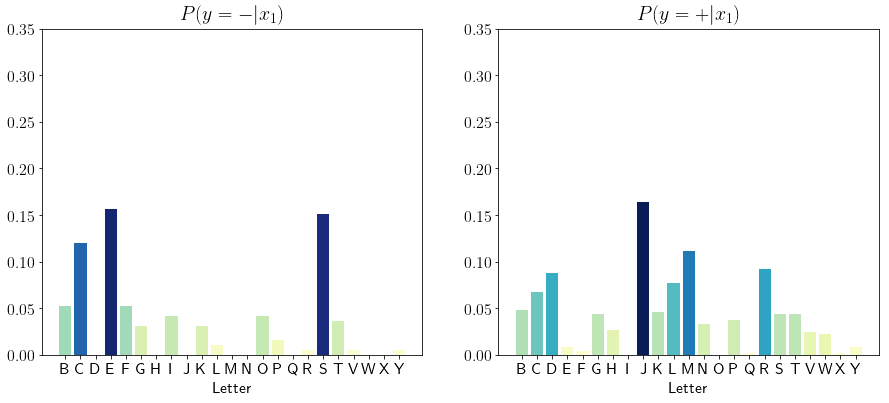

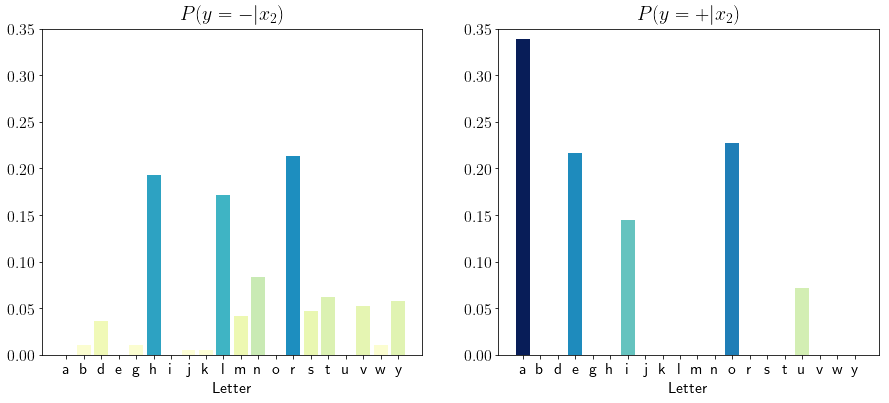

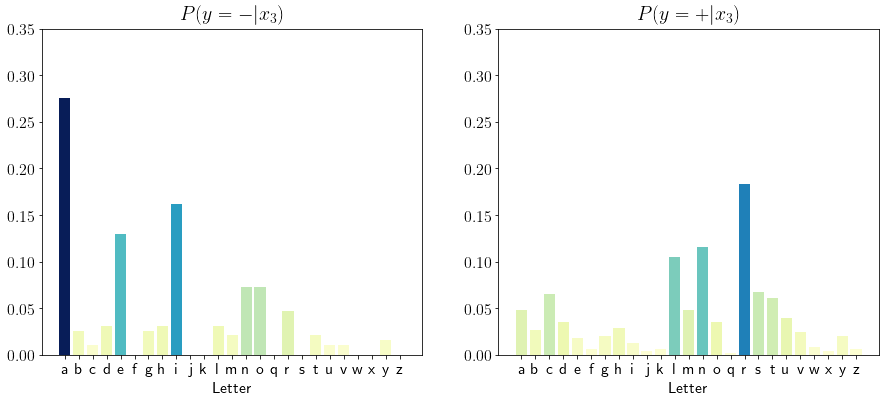

In [37]:
import matplotlib.pyplot as plt

font = {'size'   : 16}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

for pos in range(3):
    # remove space from Dictionary as it messes up the plot
    Px[pos].pop(' ',None)
    
    plt.figure(figsize=(15,6))

    lists = sorted(Px[pos].items())
    x, y = zip(*lists)
    y0 = np.array([k[0] for k in y])
    y1 = np.array([k[1] for k in y])    
    ymax = max(max(y0),max(y1))
    
    plt.subplot(121)
    colors = plt.cm.YlGnBu(y0 / (ymax))
    plt.bar(x,y0,color=colors)
    plt.title('$P(y=-|x_%d)$' % (pos+1),fontsize=20)
    plt.ylim((0,0.35))
    plt.xlabel('Letter')
    
    plt.subplot(122)
    colors = plt.cm.YlGnBu(y1 / (ymax))
    plt.title('$P(y=+|x_%d)$' % (pos+1),fontsize=20)    
    plt.bar(x,y1,color=colors)
    plt.ylim((0,0.35))    
    plt.xlabel('Letter')
    #plt.savefig('Name_histograms_pos%d.pdf' % (pos+1), bbox_inches='tight')      